<a href="https://colab.research.google.com/github/michp15/Big_Data/blob/main/graphs_setup_plot_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Analysis

## If you already saw "graphs-setup-and-plot.ipynb", you can skip parts 1-4 and move onto part 5

## 1. Project Setup & Environment

In [1]:
# Install & configure dependencies
!pip install pyspark
!pip install graphframes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.5 MB/s eta 0:00:00


In [2]:
# spark functionality
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, lit, year, month, split, explode, size, regexp_replace, trim, row_number, rand, broadcast
from pyspark.ml.feature import StringIndexer # incoding strings
from pyspark.ml.evaluation import RegressionEvaluator # for evaluation
from graphframes import GraphFrame # for graphs
from pyspark.sql.window import Window

# for visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from networkx.algorithms import bipartite # for bipartite

from google.colab import drive
from pyspark.sql import Row

In [3]:
# initialize SparkSession with GraphFrames support
spark = SparkSession.builder \
    .appName("YelpEDA_GraphAnalysis") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

# verify the session
spark

## 2. Data Ingestion

In [ ]:
business_df = spark.read.json("/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json") \
    .select("business_id", "name", "categories")
user_df = spark.read.json("/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json") \
    .select("user_id", "name", "review_count", "average_stars", "friends")
review_df = spark.read.json("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json") \
    .select("user_id", "business_id", "stars", "date")

25/05/13 16:52:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## 3. Graph Creation

In [ ]:
# create vertices for the graphs

# User vertices for friendship graph
target_user_cols = ["user_id", "name", "review_count", "average_stars"]
user_vertices = user_df.selectExpr(
    "user_id as id",
    "name",
    "review_count",
    "average_stars"
)

# Business vertices for review graph
business_vertices = business_df.selectExpr(
    "business_id as id",
    "name",
    "categories"
)

In [ ]:
# combine vertices for the bipartite graph

# we can reuse user_vertices and business_vertices, adding missing columns
u_verts = user_vertices.withColumn("categories", lit(None).cast("string"))
b_verts = business_vertices.withColumn("review_count", lit(None).cast("int")) \
                          .withColumn("average_stars", lit(None).cast("double"))
bipartite_vertices = u_verts.unionByName(b_verts)

In [ ]:
# create edges:

# create Friend edges by explode friends of each user after splitting them (User <-> User)
friend_edges = user_df.select(
    col("user_id").alias("src"),
    explode(
        split(trim(col("friends")), ", *")
    ).alias("dst")
).filter(col("dst") != "")

# review edges (User -> Business)
review_edges = review_df.selectExpr(
    "user_id as src",
    "business_id as dst",
    "stars as rating",
    "date"
)

In [ ]:
# build the graphs

g_friend = GraphFrame(user_vertices, friend_edges)
g_review = GraphFrame(business_vertices, review_edges)
g_bi = GraphFrame(bipartite_vertices, review_edges)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


## 4. Graph Visulaization

### 4.1 Plot a Small Subset of the User-Friends Graph

In [ ]:
# pick 5 low-degree users as seeds for better visuals
low_degree = friend_edges.groupBy("src") \
    .count().withColumnRenamed("count","friend_count") \
    .filter(col("friend_count") <= 10)

seed_users = low_degree.select("src").distinct().limit(10)

# for each seed, take 10 of their friends
one_hop = friend_edges.join(seed_users, "src")
w = Window.partitionBy("src").orderBy(rand())
sample_one_hop = (
    one_hop
    .withColumn("rn", row_number().over(w))
    .filter(col("rn") <= 10)
    .select("src","dst")
)

# build the induced vertex set (seeds + those friends)
vertices = (
    sample_one_hop.select(col("src").alias("id"))
    .union(sample_one_hop.select(col("dst").alias("id")))
    .distinct()
)

# pull in any edges among that vertex set (including friend <-> friend)
sub_edges = (
    friend_edges
    .join(vertices.withColumnRenamed("id","v1"), friend_edges.src == col("v1"))
    .join(vertices.withColumnRenamed("id","v2"), friend_edges.dst == col("v2"))
    .select("src","dst")
)

# map IDs -> names
user_names = user_df.select(col("user_id").alias("id"), col("name"))
named = (
    sub_edges
    .join(user_names, sub_edges.src == user_names.id)
    .select("src","dst", col("name").alias("src_name"))
    .join(
      user_names.withColumnRenamed("id","dst_id")
                .withColumnRenamed("name","dst_name"),
      sub_edges.dst == col("dst_id")
    )
    .select("src_name","dst_name")
)

# collect just this tiny subgraph and plot
pdf = named.toPandas()
Gf = nx.from_pandas_edgelist(pdf, "src_name", "dst_name")

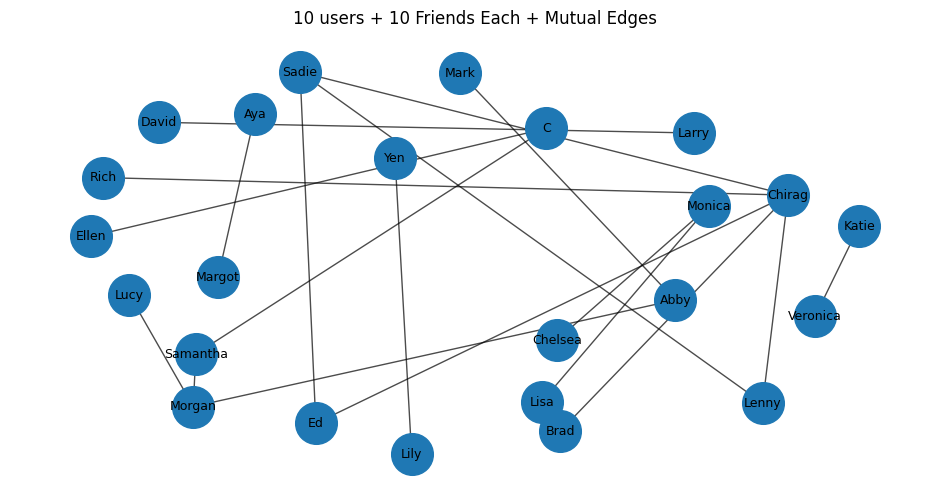

In [ ]:
pos = nx.spring_layout(Gf, k=0.8, iterations=10, seed=2)
plt.figure(figsize=(12,6))
nx.draw_networkx_nodes(Gf, pos, node_size=900)
nx.draw_networkx_edges(Gf, pos, alpha=0.7)
nx.draw_networkx_labels(Gf, pos, font_size=9)
plt.title("10 users + 10 Friends Each + Mutual Edges")
plt.axis("off")
plt.show()

### 4.2 Bipartite Plot for Users and Businesses

In [ ]:
# pick 5 businesses with more than 2 reviews
biz_pop = (
    review_df.groupBy("business_id").count()
             .filter(col("count") >= 2)
             .orderBy(rand())
             .select(col("business_id"))
             .limit(5)
)

# for each business, sample up to 5 distinct users who reviewed it
rev = review_edges.select(col("src").alias("user_id"), col("dst").alias("business_id"))
biz_window = Window.partitionBy("business_id").orderBy(rand())
sample_ub = (
    rev.join(biz_pop, "business_id")
       .withColumn("rn", row_number().over(biz_window))
       .filter(col("rn") <= 5)
       .select("user_id", "business_id")
       .distinct()
)

# build vertex set (users + businesses)
vb = (
    sample_ub.select(col("user_id").alias("id"))
             .union(sample_ub.select(col("business_id").alias("id")))
             .distinct()
)

# pull in any edges among that vertex set (ensure user–biz edges)
sub_edges = (
    rev.join(vb.withColumnRenamed("id","u"), rev.user_id == col("u"))
       .join(vb.withColumnRenamed("id","b"), rev.business_id == col("b"))
       .select(col("user_id"), col("business_id"))
)

# map IDs → names
users = user_df.select(col("user_id").alias("user_id"), col("name").alias("user_name"))
bizs  = business_df.select(col("business_id"), col("name"))

named = (
    sub_edges
      .join(users, "user_id")
      .join(bizs, "business_id")
      .select("user_name", "name")
)

# also bring the rating into pandas dataframe
small_rev = (
    review_df
      .join(sub_edges, ["user_id","business_id"])
      .select("user_id","business_id","stars")
)

# map IDs -> names in Spark
named = (
    small_rev
    .join(user_df.select("user_id", col("name").alias("user_name")), "user_id")
    .join(business_df.select("business_id", col("name")), "business_id")
    .select("user_name","name","stars")
)

# now collect
pdf = named.toPandas()

B = nx.Graph()
B.add_nodes_from(pdf["user_name"].unique(), bipartite=0)
B.add_nodes_from(pdf["name"].unique(), bipartite=1)
B.add_edges_from(list(zip(pdf["user_name"], pdf["name"])))

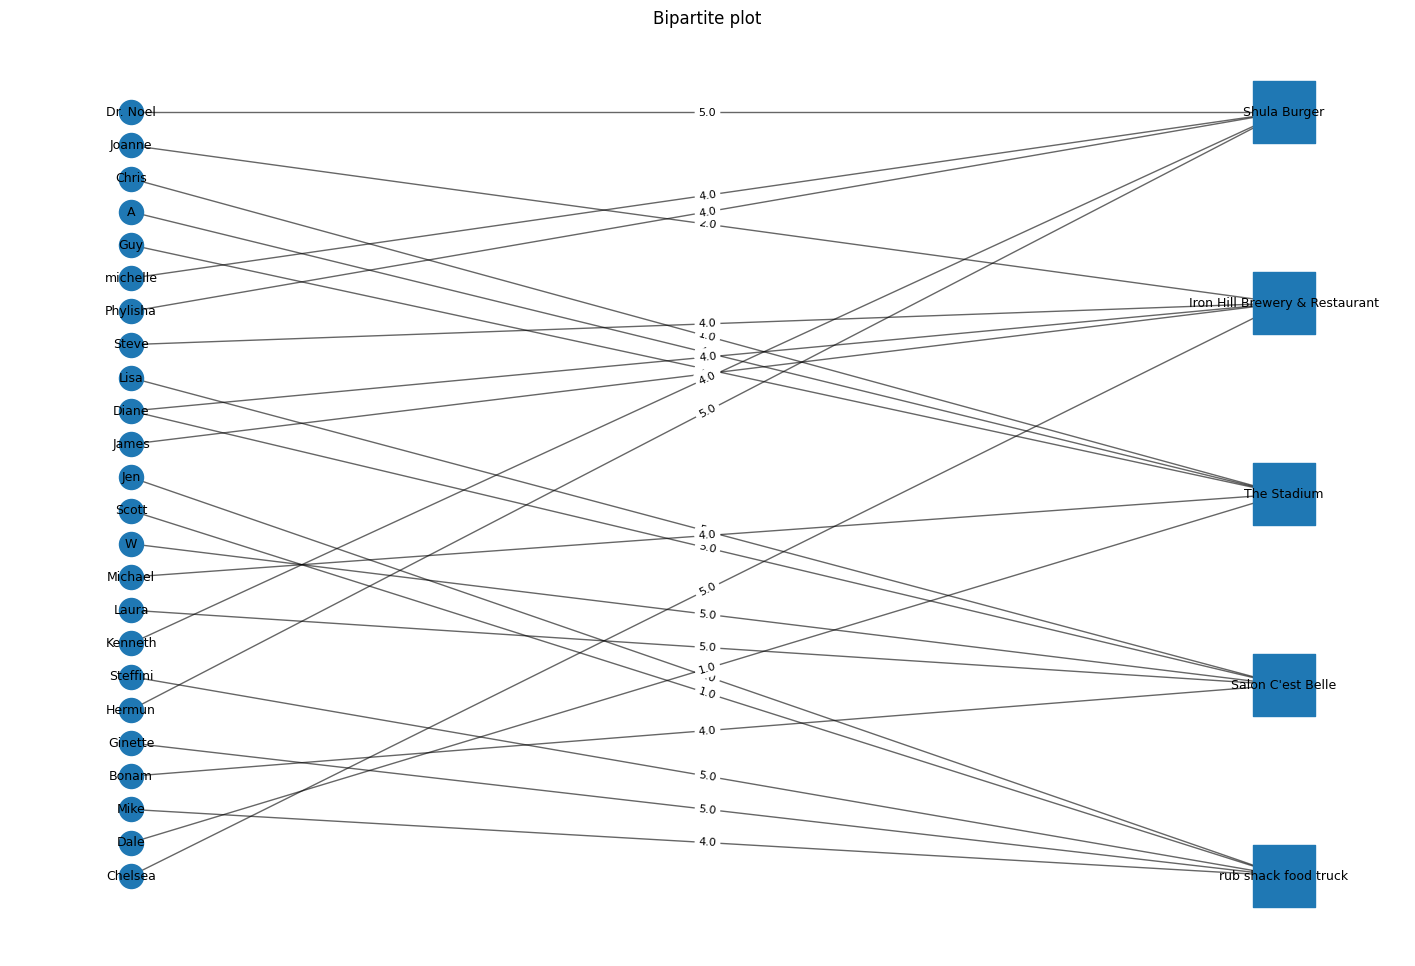

In [ ]:
users = pdf['user_name'].unique().tolist()
business = pdf['name'].unique().tolist()

pos = {
    u: (0, 1 - idx/(len(users)-1))
    for idx, u in enumerate(users)
}
pos.update({
    b: (1, 1 - idx/(len(business)-1))
    for idx, b in enumerate(business)
})

edge_labels = {
    (row.user_name, row['name']): row.stars
    for _, row in pdf.iterrows()
}

plt.figure(figsize=(18,12))
nx.draw_networkx_nodes(B, pos, nodelist=users,    node_size=300)
nx.draw_networkx_nodes(B, pos, nodelist=business, node_shape='s', node_size=2000)
nx.draw_networkx_edges(B, pos, alpha=0.6)
nx.draw_networkx_labels(B, pos, font_size=9)
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_size=8)
plt.title("Bipartite plot")
plt.axis('off')
plt.show()

# 5. Graph Algorithms

## PageRank

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
user = spark.read.parquet("/content/drive/MyDrive/2nd semester msc/Big Data/project/user.parquet")

In [7]:
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [8]:
user.show(5)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+----------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|     elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+----------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|         4.73|              1|              0|     

In [9]:
vertices = user.selectExpr("user_id as id").distinct() #choose distinct userIDs and rename the column to id

In [10]:
#creates edges by splitting the friends column into individual friend IDs, trimming spaces and renaming columns to src and std
edges = user.select("user_id", "friends") \
    .withColumn("friend", explode(split("friends", ","))) \
    .withColumn("friend", trim("friend")) \
    .selectExpr("user_id as src", "friend as dst") \
    .filter("dst != ''")

In [11]:
g = GraphFrame(vertices, edges)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [ ]:
#user.count() doesn't need to run this because it takes a while, 1987897

### Taking a sample of 100k since 2m rows are too many even for collab

In [ ]:
duplicates = user.groupBy("user_id") \
    .agg(count("*").alias("count")) \
    .filter("count > 1")

duplicates.show()

+-------+-----+
|user_id|count|
+-------+-----+
+-------+-----+



In [12]:
pagerank_result = g.pageRank(resetProbability=0.15, maxIter=5)
pagerank_result.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False).show(5, truncate = False)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+----------------------+------------------+
|id                    |pagerank          |
+----------------------+------------------+
|WwulXySQN8t2hwqH_yWurA|963.059136417376  |
|vHc-UrI9yfL_pnnc6nJtyQ|704.3204784748202 |
|AHRrG3T1gJpHvtpZ-K0G_g|551.3416613972128 |
|Oi1qbcz2m2SnwUeztGYcnQ|459.63451094281885|
|6jjHo9Lilv3kTy87pm2ycw|454.76757104591763|
+----------------------+------------------+
only showing top 5 rows



In [16]:
# Get top 10 users in terms of PageRank and find them in user dataset and print their name

top_10_user = pagerank_result.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False).take(10)
top_10_user_ids = [row.id for row in top_10_user]
top_10_users = user.filter(user.user_id.isin(top_10_user_ids))
top_10_users.select("user_id", "name").show(truncate=False)

+----------------------+---------+
|user_id               |name     |
+----------------------+---------+
|mGHP3esQQqCEicHLRV-g5Q|Cara     |
|6jjHo9Lilv3kTy87pm2ycw|Kaitlyn  |
|Oi1qbcz2m2SnwUeztGYcnQ|Steven   |
|AHRrG3T1gJpHvtpZ-K0G_g|Brittany |
|vHc-UrI9yfL_pnnc6nJtyQ|Michael  |
|-kLVfaJytOJY2-QdQoCcNQ|Christina|
|WwulXySQN8t2hwqH_yWurA|Niki     |
|ET8n-r7glWYqZhuR6GcdNw|Michelle |
|djxnI8Ux8ZYQJhiOQkrRhA|Abby     |
|BmVwbsL8l0imz4slonyMaA|Morris   |
+----------------------+---------+



In [17]:
communities = g.labelPropagation(maxIter=5)
communities.select("id", "label").orderBy("label").show()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------------------+-----+
|                  id|label|
+--------------------+-----+
|--RJK834fiQXm21Vp...|    0|
|--UhENQdbuWEh0mU5...|    1|
|-0EzgKMI9ZakqLiWR...|    3|
|-0XPr1ilUAfp-yIXZ...|    4|
|-1-5YlK9t1Jgp6TbW...|    6|
|-15T9XlC72uvJdKJ4...|    7|
|-1BSu2dt_rOAqllw9...|    8|
|-1ba3W4bYAMEod5Gf...|    9|
|-1pYmX4TNNqmvJZ5n...|   11|
|-2G_a0eur5RTmI-vc...|   12|
|-2IwE8_2pTsIKlEjE...|   13|
|-2WtPPlWod94lhjKO...|   14|
|-43vn4eU9nQbfn4WC...|   17|
|-4eoHNVezSKo9FkrA...|   18|
|-6mqEHZTdqoS98jyT...|   21|
|-7mhLPkdpCQnHBY1r...|   22|
|-81NcUjHhigZtIkDW...|   23|
|-BIsieBb59f9OBiwf...|   31|
|-BNm6NZ_qcsccFUKn...|   32|
|-BbN4tclWAvrHoO7d...|   33|
+--------------------+-----+
only showing top 20 rows



In [18]:
spark.sparkContext.setCheckpointDir("/tmp/graphframes-checkpoint")
connected_components = g.connectedComponents()
connected_components.select("id", "component").show(5)

+--------------------+-----------+
|                  id|  component|
+--------------------+-----------+
|--RJK834fiQXm21Vp...|          0|
|--z9XJZF0T2r7aIsZ...| 8589934592|
|-2XgFRSn4Cl1QIHc6...| 8589934596|
|--vbugbG0uZMzODyt...|25769803780|
|--Vu3Gux9nPnLcG9y...|          2|
+--------------------+-----------+
only showing top 5 rows



In [19]:
vertices.select("id").show(5, truncate=False)

+----------------------+
|id                    |
+----------------------+
|ewPehLq02_5dki22K52t0g|
|gsAzz6f9pvyOUuli3KxyWQ|
|7lPDczfvgr5KsmjPSMGbAw|
|lvxpndNDrsMSpMvpQhw9QA|
|f746XMC9RVLX1wZizZ89hA|
+----------------------+
only showing top 5 rows



In [20]:
shortest_paths = g.shortestPaths(landmarks=["7lPDczfvgr5KsmjPSMGbAw", "lvxpndNDrsMSpMvpQhw9QA"])
shortest_paths.select("id", "distances").show(5)

+--------------------+--------------------+
|                  id|           distances|
+--------------------+--------------------+
|--RJK834fiQXm21Vp...|                  {}|
|-15T9XlC72uvJdKJ4...|                  {}|
|-55DgUo52I3zW9Rxk...|{7lPDczfvgr5KsmjP...|
|-7mhLPkdpCQnHBY1r...|                  {}|
|-9da1xk7zgnnfO1uT...|{7lPDczfvgr5KsmjP...|
+--------------------+--------------------+
only showing top 5 rows



In [22]:
shortest_paths.select("id", "distances").show(truncate=False)

+----------------------+----------------------------------------------------------+
|id                    |distances                                                 |
+----------------------+----------------------------------------------------------+
|--RJK834fiQXm21VpJp_nw|{}                                                        |
|-15T9XlC72uvJdKJ4zFILQ|{}                                                        |
|-55DgUo52I3zW9RxkZ-EAQ|{7lPDczfvgr5KsmjPSMGbAw -> 5, lvxpndNDrsMSpMvpQhw9QA -> 5}|
|-7mhLPkdpCQnHBY1rDBH_g|{}                                                        |
|-9da1xk7zgnnfO1uTVYGkA|{7lPDczfvgr5KsmjPSMGbAw -> 4, lvxpndNDrsMSpMvpQhw9QA -> 4}|
|-Auhegi8KEKW7iR8IlXCmA|{7lPDczfvgr5KsmjPSMGbAw -> 5, lvxpndNDrsMSpMvpQhw9QA -> 3}|
|-CM12dCzyhW7RNr9SQPe0Q|{7lPDczfvgr5KsmjPSMGbAw -> 5, lvxpndNDrsMSpMvpQhw9QA -> 5}|
|-GjDETervpsqA_jEKbHgHg|{}                                                        |
|-I7-ddMuzc1SY8PILd6Srw|{}                                                  